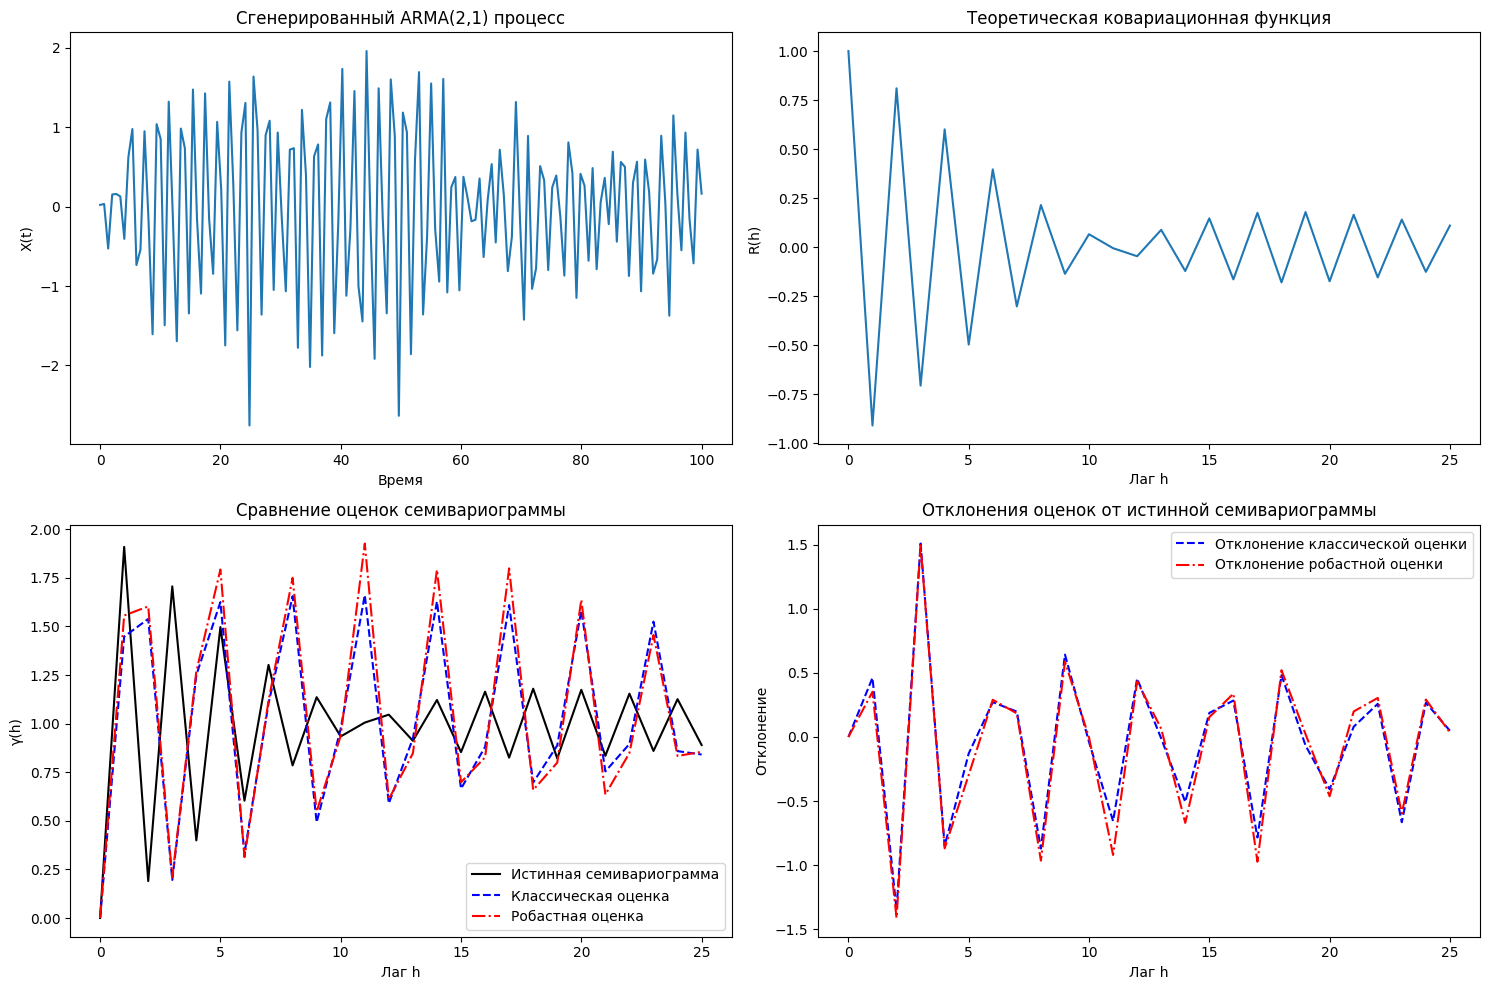

In [2]:
#первая часть
import numpy as np
import matplotlib.pyplot as plt

#Теоретическая ковариационная функция
def theoretical_cov(h, D=1.0, alpha=0.15, beta=3.0):
    return D * np.exp(-alpha*np.abs(h)) * np.cos(beta*h)

#Генерация процесса методом ARMA(2,1)
def generate_arma_process(n=150, T=100.0, D=1.0, alpha=0.15, beta=3.0):
    dt = T / n
    gamma = alpha * dt
    gamma0 = beta * dt

    alpha_0 = np.exp(-gamma) * (np.exp(-2*gamma) - 1) * np.cos(gamma0)
    alpha1 = 1 - np.exp(-4*gamma)

    a0 = np.sqrt(D) * alpha
    a1 = np.sqrt(D) * (alpha_0 / alpha)
    b1 = 2 * np.exp(-gamma) * np.cos(gamma0)
    b2 = -np.exp(-2 * gamma)

    # Генерация белого шума
    np.random.seed(43)
    x = np.random.normal(0, 1, n)

    # Инициализация процесса
    xi = np.zeros(n)
    xi[0] = a0 * x[0]
    xi[1] = a0 * x[1] + a1 * x[0] + b1 * xi[0]

    # Рекуррентное вычисление
    for k in range(2, n):
        xi[k] = a0 * x[k] + a1 * x[k-1] + b1 * xi[k-1] + b2 * xi[k-2]

    return xi

#Истинная семивариограмма
def true_semivariogram(h, D=1.0, alpha=0.15, beta=3.0):
    return D * (1 - np.exp(-alpha*np.abs(h)) * np.cos(beta*h))

#Классическая оценка семивариограммы
def classical_semivariogram_estimate(X, h_max):
    n = len(X)
    gamma_hat = np.zeros(h_max + 1)
    
    for h in range(h_max + 1):
        if h < n:
            diffs = (X[h:] - X[:n-h])**2
            gamma_hat[h] = np.sum(diffs) / (2 * (n - h))
        else:
            gamma_hat[h] = 0
    
    return gamma_hat

#Робастная оценка семивариограммы
def robust_semivariogram_estimate(X, h_max):
    n = len(X)
    gamma_hat_rob = np.zeros(h_max + 1)
    
    for h in range(h_max + 1):
        if h < n:
            abs_diffs = np.abs(X[h:] - X[:n-h])
            term1 = np.mean(abs_diffs**0.5)
            denominator = 2 * (0.457 + 0.494/(n-h) + 0.045/(n-h)**2)
            gamma_hat_rob[h] = (term1**4) / denominator
        else:
            gamma_hat_rob[h] = 0
    
    return gamma_hat_rob

# Параметры моделирования
n = 150
h_max = 25  # максимальный лаг для оценки
D = 1.0
alpha = 0.085
beta = 3.0
T = 100.0

# Моделирование процесса
X = generate_arma_process(n, T, D, alpha, beta)

# Истинная семивариограмма
h_values = np.arange(h_max + 1)
true_gamma = [true_semivariogram(h, D, alpha, beta) for h in h_values]

# Оценки семивариограммы
gamma_hat_classic = classical_semivariogram_estimate(X, h_max)
gamma_hat_robust = robust_semivariogram_estimate(X, h_max)

# Визуализация
plt.figure(figsize=(15, 10))

# График наблюдений процесса
plt.subplot(2, 2, 1)
plt.plot(np.linspace(0, T, n), X)
plt.title('Сгенерированный ARMA(2,1) процесс')
plt.xlabel('Время')
plt.ylabel('X(t)')

# График ковариационной функции
plt.subplot(2, 2, 2)
cov_values = [theoretical_cov(h, D, alpha, beta) for h in h_values]
plt.plot(h_values, cov_values)
plt.title('Теоретическая ковариационная функция')
plt.xlabel('Лаг h')
plt.ylabel('R(h)')

# График семивариограмм
plt.subplot(2, 2, 3)
plt.plot(h_values, true_gamma, 'k-', label='Истинная семивариограмма')
plt.plot(h_values, gamma_hat_classic, 'b--', label='Классическая оценка')
plt.plot(h_values, gamma_hat_robust, 'r-.', label='Робастная оценка')
plt.title('Сравнение оценок семивариограммы')
plt.xlabel('Лаг h')
plt.ylabel('γ(h)')
plt.legend()

# График отклонений
deviation_classic = np.array(true_gamma) - gamma_hat_classic
deviation_robust = np.array(true_gamma) - gamma_hat_robust
plt.subplot(2, 2, 4)
plt.plot(h_values, deviation_classic, 'b--', label='Отклонение классической оценки')
plt.plot(h_values, deviation_robust, 'r-.', label='Отклонение робастной оценки')
plt.title('Отклонения оценок от истинной семивариограммы')
plt.xlabel('Лаг h')
plt.ylabel('Отклонение')
plt.legend()

plt.tight_layout()
plt.show()

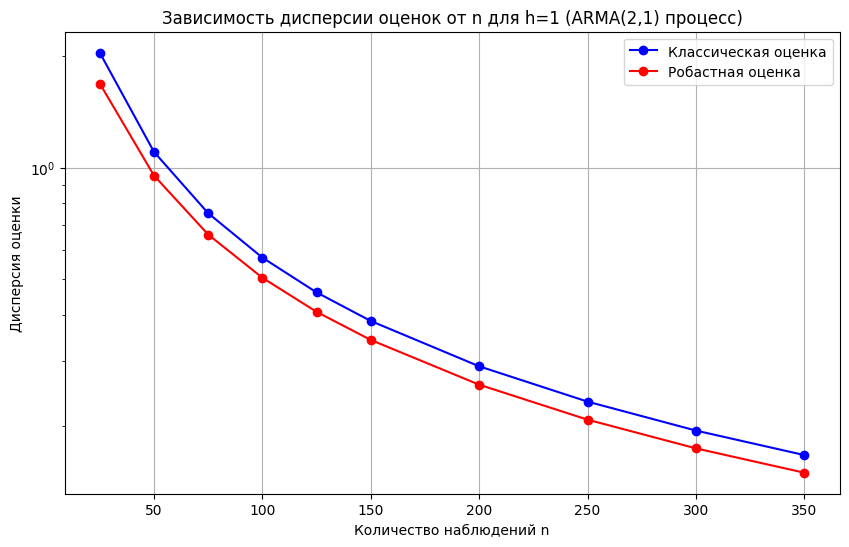

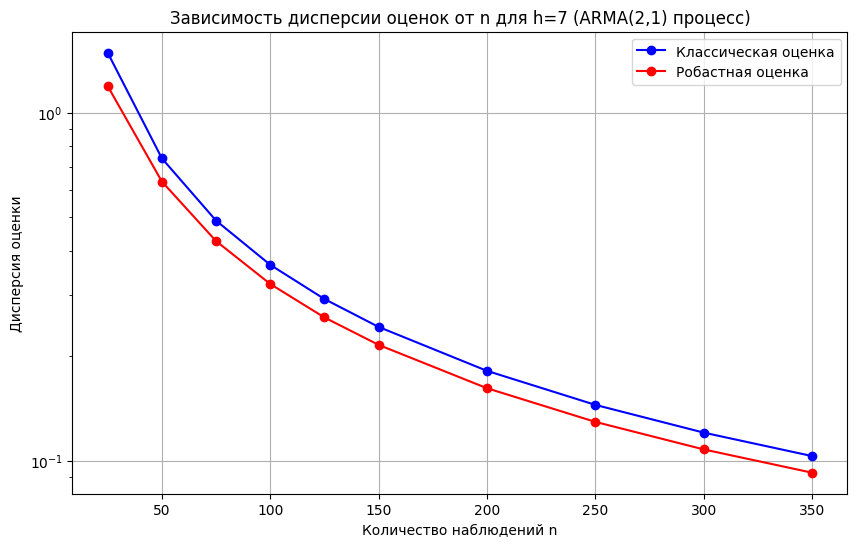

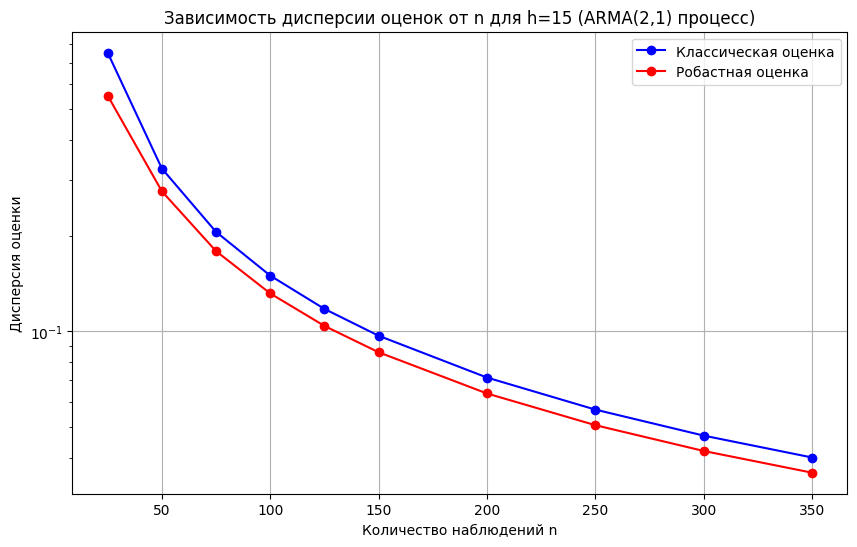


+-------------------------+------------+------------+------------+------------+------------+------------+
|количество наблюдений, n |          h = 1          |          h = 7          |         h = 15          |
+-------------------------+------------+------------+------------+------------+------------+------------+
|                         | D_classic  |  D_robust  | D_classic  |  D_robust  | D_classic  |  D_robust  |
+-------------------------+------------+------------+------------+------------+------------+------------+
|           25            |  2.045768  |  1.688147  |  1.486886  |  1.192161  |  0.751869  |  0.551033  |
+-------------------------+------------+------------+------------+------------+------------+------------+
|           50            |  1.103197  |  0.951978  |  0.739293  |  0.634116  |  0.324826  |  0.275502  |
+-------------------------+------------+------------+------------+------------+------------+------------+
|           75            |  0.752866  |  0.6

In [1]:
#вторая часть
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

# 1. Функции для моделирования процесса и вычисления семивариограммы
def theoretical_cov(h, D=1.0, alpha=0.15, beta=3.0):
    return D * np.exp(-alpha*np.abs(h)) * np.cos(beta*h)

def generate_arma_process(n=150, T=100.0, D=1.0, alpha=0.15, beta=3.0):
    dt = T / n
    gamma_val = alpha * dt
    gamma0 = beta * dt

    alpha0 = np.exp(-gamma_val) * (np.exp(-2*gamma_val) - 1) * np.cos(gamma0)
    alpha1 = 1 - np.exp(-4*gamma_val)

    a0 = np.sqrt(D) * alpha
    a1 = np.sqrt(D) * (alpha0 / alpha)
    b1 = 2 * np.exp(-gamma_val) * np.cos(gamma0)
    b2 = -np.exp(-2*gamma_val)

    np.random.seed(42)
    x = np.random.normal(0, 1, n)

    xi = np.zeros(n)
    xi[0] = a0 * x[0]
    xi[1] = a0 * x[1] + a1 * x[0] + b1 * xi[0]

    for k in range(2, n):
        xi[k] = a0 * x[k] + a1 * x[k-1] + b1 * xi[k-1] + b2 * xi[k-2]

    return xi

def true_semivariogram(h, cov_func):
    return cov_func(0) - cov_func(h)

# 2. Функции для вычисления дисперсий оценок
def classic_variance(gamma_func, n, h):
    total = 0.0
    for s in range(1, n-h+1):
        for t in range(1, n-h+1):
            term = gamma_func(abs(s-t + h)) + gamma_func(abs(s-t - h)) - 2*gamma_func(abs(s-t))
            total += term**2
    return total / (2*(n-h)**2)

def robust_variance(gamma_func, n, h):
    gamma_34 = gamma(3/4)
    pi = np.pi
    C1 = (np.pi**(-0.5) - gamma_34**2/pi) * gamma_34**6 / pi**3
    denominator = (0.457 + 0.494/(n-h) + 0.045/(n-h)**2)**2
    
    total = 0.0
    for s in range(1, n-h+1):
        for t in range(1, n-h+1):
            term = gamma_func(abs(s-t + h)) + gamma_func(abs(s-t - h)) - 2*gamma_func(abs(s-t))
            total += term**2
    
    return (10 * C1 * total) / ((n-h)**2 * denominator)

# 3. Параметры исследования
n_values = [25, 50, 75, 100, 125, 150, 200, 250, 300, 350]
h_values = [1, 7, 15]
D = 1.0
alpha = 0.085
beta = 3.0
T = 100.0

# 4. Исследование для каждого h
results = {}
for h in h_values:
    classic_vars = []
    robust_vars = []
    for n in n_values:
        gamma_func = lambda x: true_semivariogram(x, lambda y: theoretical_cov(y, D, alpha, beta))
        classic_var = classic_variance(gamma_func, n, h)
        robust_var = robust_variance(gamma_func, n, h)
        classic_vars.append(classic_var)
        robust_vars.append(robust_var)
    results[h] = {'D_classic': classic_vars, 'D_robust': robust_vars}

    plt.figure(figsize=(10, 6))
    plt.plot(n_values, classic_vars, 'bo-', label='Классическая оценка')
    plt.plot(n_values, robust_vars, 'ro-', label='Робастная оценка')
    plt.title(f'Зависимость дисперсии оценок от n для h={h} (ARMA(2,1) процесс)')
    plt.xlabel('Количество наблюдений n')
    plt.ylabel('Дисперсия оценки')
    plt.yscale('log')  # Логарифмическая шкала для лучшей визуализации
    plt.grid(True)
    plt.legend()
    plt.show()

#5.Вывод результатов
n_width = 25  # Ширина столбца с n
d_width = 12   # Ширина столбцов с дисперсиями

# Функция для создания горизонтальной линии
def make_line():
    line = "+" + "-" * n_width + "+"
    for _ in h_values:
        line += "-" * d_width + "+" + "-" * d_width + "+"
    return line

# Верхняя граница таблицы
print("\n" + make_line())

# Заголовок с лагами
header = f"|{'количество наблюдений, n':^{n_width}}|"
for h in h_values:
    header += f"{f'h = {h}':^{2*d_width+1}}|"
print(header)

# Линия под заголовком
print(make_line())

# Подзаголовки с типами дисперсий
subheader = f"|{' ' * n_width}|"
for _ in h_values:
    subheader += f"{'D_classic':^{d_width}}|{'D_robust':^{d_width}}|"
print(subheader)

# Основные данные
print(make_line())
for i, n in enumerate(n_values):
    row = f"|{n:^{n_width}}|"
    for h in h_values:
        classic = f"{results[h]['D_classic'][i]:.6f}"
        robust = f"{results[h]['D_robust'][i]:.6f}"
        row += f"{classic:^{d_width}}|{robust:^{d_width}}|"
    print(row)
    print(make_line())